In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix, 
                              classification_report)
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

2025-10-23 18:14:16.915131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761243257.177465      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761243257.252554      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("="*80)
print("OPTIMIZED CUSTOM CNN - TEA LEAF DISEASE DETECTION")
print("="*80)

# ============================================================================
# 1. DATA LOADING WITH ENHANCED AUGMENTATION
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DATASET WITH ADVANCED AUGMENTATION")
print("="*80)

# Dataset paths
# Correct base directory
base_dir = "/kaggle/input/final-preprocessed-dataset-20251023t053720z-1-001/Final_Preprocessed_Dataset"

# Define subdirectories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16  # Reduced for better generalization

# Enhanced augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_data.class_indices)
print(f"\nDetected Classes: {train_data.class_indices}")

OPTIMIZED CUSTOM CNN - TEA LEAF DISEASE DETECTION

STEP 1: LOADING DATASET WITH ADVANCED AUGMENTATION
Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.
Found 597 images belonging to 5 classes.

Detected Classes: {'1. Tea algal leaf spot': 0, '2. Brown Blight': 1, '4. Helopeltis': 2, '5. Red spider': 3, '7. Healthy leaf': 4}


In [3]:
# ============================================================================
# 2. OPTIMIZED MODEL HYPERPARAMETERS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: DEFINING OPTIMIZED HYPERPARAMETERS")
print("="*80)

hyperparams = {
    'num_conv_blocks': 4,
    'filters': [64, 128, 256, 512],
    'kernel_size': (3, 3),
    'activation': 'relu',
    'dropout_rate': 0.5,
    'optimizer': 'adam',
    'learning_rate': 0.0001,
    'batch_size': BATCH_SIZE,
    'epochs': 50
}

for k, v in hyperparams.items():
    print(f"{k}: {v}")


STEP 2: DEFINING OPTIMIZED HYPERPARAMETERS
num_conv_blocks: 4
filters: [64, 128, 256, 512]
kernel_size: (3, 3)
activation: relu
dropout_rate: 0.5
optimizer: adam
learning_rate: 0.0001
batch_size: 16
epochs: 50


In [4]:
# ============================================================================
# 3. ENHANCED MODEL ARCHITECTURE
# ============================================================================
print("\n" + "="*80)
print("STEP 3: BUILDING OPTIMIZED CUSTOM CNN MODEL")
print("="*80)

def build_optimized_cnn(hp, input_shape=(224,224,3), num_classes=6):
    model = models.Sequential(name="Optimized_CNN_TeaLeaf")
    
    model.add(layers.Input(shape=input_shape))
    
    # Convolutional blocks with batch normalization
    for i in range(hp['num_conv_blocks']):
        # Double Conv layers per block for deeper feature extraction
        model.add(layers.Conv2D(hp['filters'][i], hp['kernel_size'], 
                                activation=hp['activation'], padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(hp['filters'][i], hp['kernel_size'], 
                                activation=hp['activation'], padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(hp['dropout_rate']/2))
    
    # Global Average Pooling instead of Flatten (reduces overfitting)
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense layers with regularization
    model.add(layers.Dense(512, activation=hp['activation'], 
                           kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(hp['dropout_rate']))
    model.add(layers.Dense(256, activation=hp['activation'],
                           kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(hp['dropout_rate']))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

model = build_optimized_cnn(hyperparams, num_classes=NUM_CLASSES)
model.summary()


STEP 3: BUILDING OPTIMIZED CUSTOM CNN MODEL


I0000 00:00:1761243302.035063      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761243302.035944      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Optimized_CNN_TeaLeaf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,088,325 (19.41 MB)

 Trainable params: 5,084,485 (19.40 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [5]:
# ============================================================================
# 4. COMPILE MODEL WITH OPTIMAL SETTINGS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: COMPILING MODEL")
print("="*80)

optimizer = keras.optimizers.Adam(
    learning_rate=hyperparams['learning_rate'],
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✓ Model compiled successfully")


STEP 4: COMPILING MODEL
✓ Model compiled successfully


In [6]:
# ============================================================================
# 5. ENHANCED CALLBACKS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: CONFIGURING ADVANCED CALLBACKS")
print("="*80)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_optimized_cnn_tealeaf.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks ready: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint")


STEP 5: CONFIGURING ADVANCED CALLBACKS
✓ Callbacks ready: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [7]:
# ============================================================================
# 6. TRAINING WITH CLASS WEIGHTS (if imbalanced)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: TRAINING OPTIMIZED MODEL")
print("="*80)

# Calculate class weights for imbalanced datasets
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Start timing
start_time = time.time()

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=hyperparams['epochs'],
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Calculate training time
training_time = time.time() - start_time
print(f"\nTraining completed in: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


STEP 6: TRAINING OPTIMIZED MODEL
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761243335.359216     126 service.cc:148] XLA service 0x7e8140002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761243335.361016     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761243335.361043     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761243336.430943     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761243362.014520     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2805 - auc: 0.5903 - loss: 2.7944 - precision: 0.2909 - recall: 0.1233
Epoch 1: val_accuracy improved from -inf to 0.20134, saving model to best_optimized_cnn_tealeaf.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 415ms/step - accuracy: 0.2807 - auc: 0.5906 - loss: 2.7924 - precision: 0.2914 - recall: 0.1232 - val_accuracy: 0.2013 - val_auc: 0.5511 - val_loss: 2.8304 - val_precision: 0.2013 - val_recall: 0.2013 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4098 - auc: 0.7361 - loss: 2.2036 - precision: 0.5393 - recall: 0.1586
Epoch 2: val_accuracy did not improve from 0.20134
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.4099 - auc: 0.7362 - loss: 2.2033 - precision: 0.5394 - recall: 0.1588 - val_accuracy: 0.2013 - val_auc: 0.5211 - val_loss: 3.9114 - val_precision: 0.2013 - val_recall: 0.2013 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - 


STEP 7: VISUALIZING TRAINING HISTORY


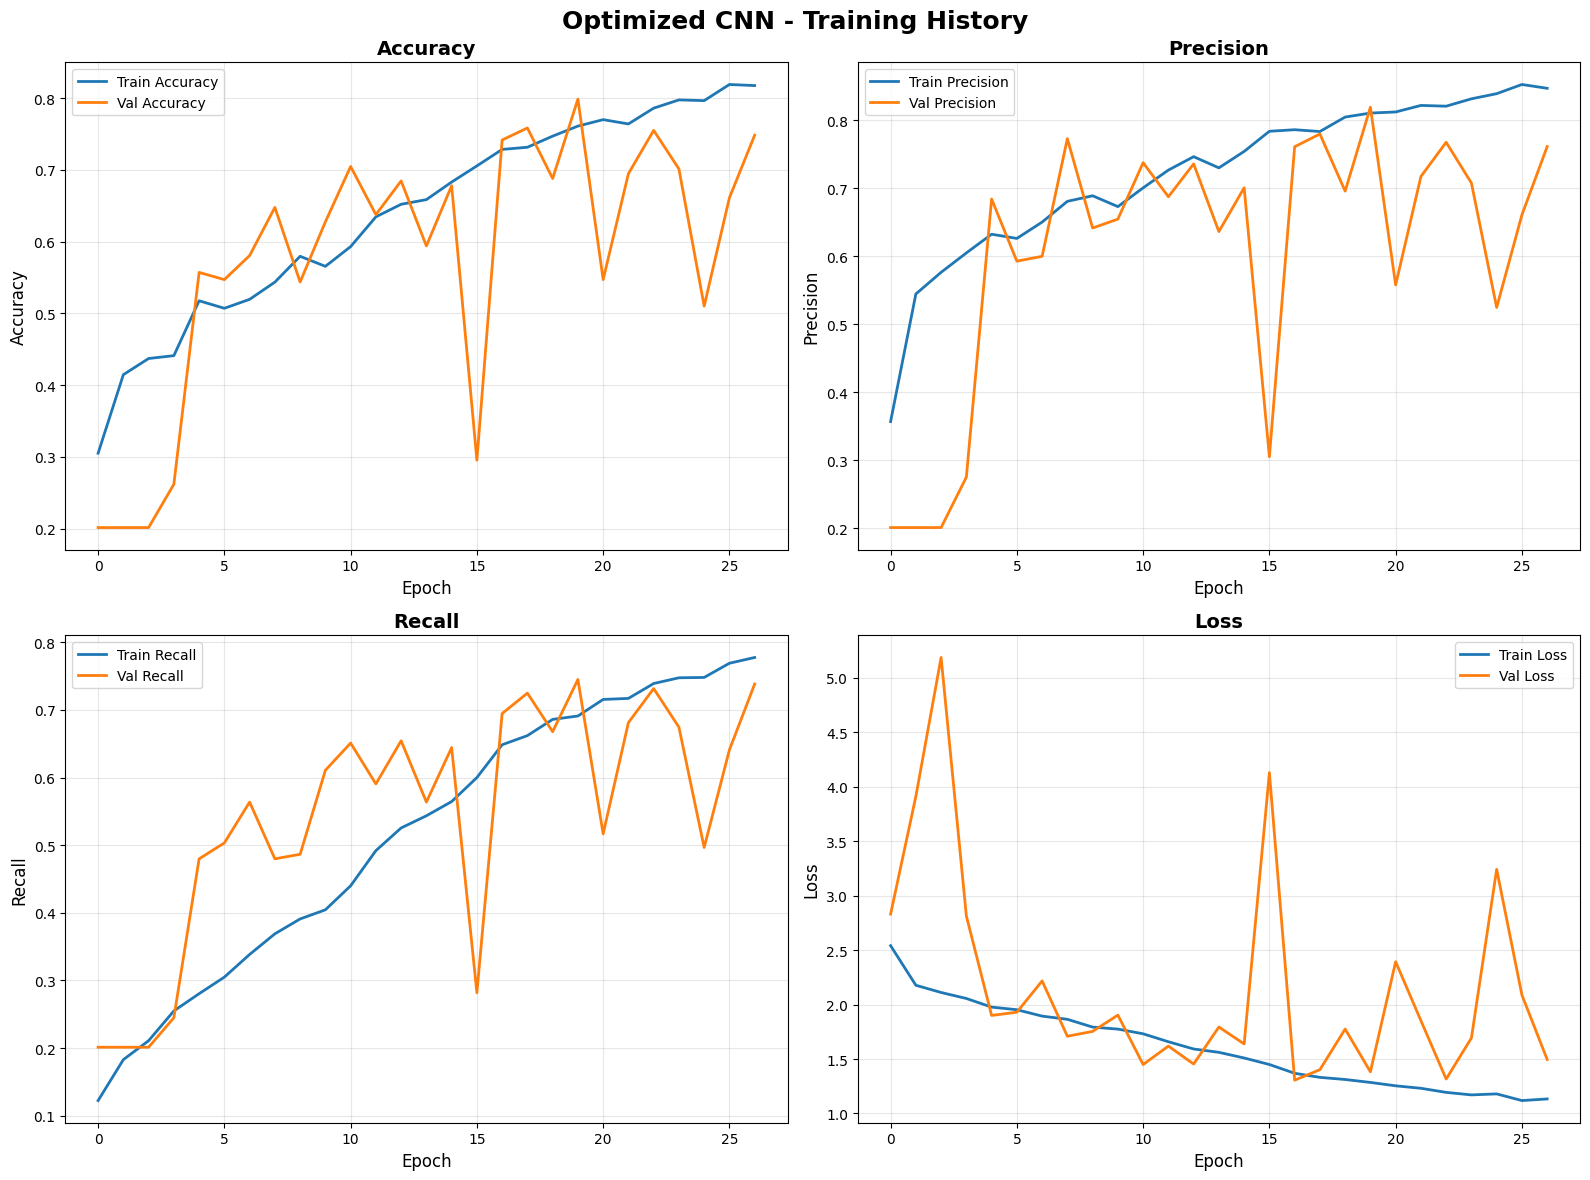

In [8]:
# ============================================================================
# 7. TRAINING VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("STEP 7: VISUALIZING TRAINING HISTORY")
print("="*80)

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    fig.suptitle("Optimized CNN - Training History", fontsize=18, fontweight='bold')
    
    metrics = ['accuracy', 'precision', 'recall', 'loss']
    titles = ['Accuracy', 'Precision', 'Recall', 'Loss']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        ax.plot(history.history[metric], label=f"Train {title}", linewidth=2)
        ax.plot(history.history[f"val_{metric}"], label=f"Val {title}", linewidth=2)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [9]:
# ============================================================================
# 8. TEST EVALUATION WITH TEST-TIME AUGMENTATION
# ============================================================================
print("\n" + "="*80)
print("STEP 8: TEST SET EVALUATION WITH TTA")
print("="*80)

best_model = keras.models.load_model('best_optimized_cnn_tealeaf.keras')

# Test-Time Augmentation (TTA) for better predictions
def predict_with_tta(model, data, n_augmentations=5):
    """Predict with Test-Time Augmentation"""
    predictions = []
    
    # Original predictions
    pred = model.predict(data)
    predictions.append(pred)
    
    # Reset test data
    data.reset()
    
    # Augmented predictions
    tta_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    for i in range(n_augmentations - 1):
        tta_data = tta_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )
        pred = model.predict(tta_data)
        predictions.append(pred)
    
    # Average predictions
    return np.mean(predictions, axis=0)

print("Applying Test-Time Augmentation...")
Y_pred = predict_with_tta(best_model, test_data, n_augmentations=5)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), Y_pred, multi_class='ovr')

print(f"\n{'='*40}")
print("TEST SET RESULTS (with TTA)")
print(f"{'='*40}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


STEP 8: TEST SET EVALUATION WITH TTA
Applying Test-Time Augmentation...
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step
Found 597 images belonging to 5 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step
Found 597 images belonging to 5 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step
Found 597 images belonging to 5 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step
Found 597 images belonging to 5 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

TEST SET RESULTS (with TTA)
Accuracy:  0.7504
Precision: 0.8100
Recall:    0.7504
F1-Score:  0.7409
AUC:       0.9554



STEP 9: CONFUSION MATRIX VISUALIZATION


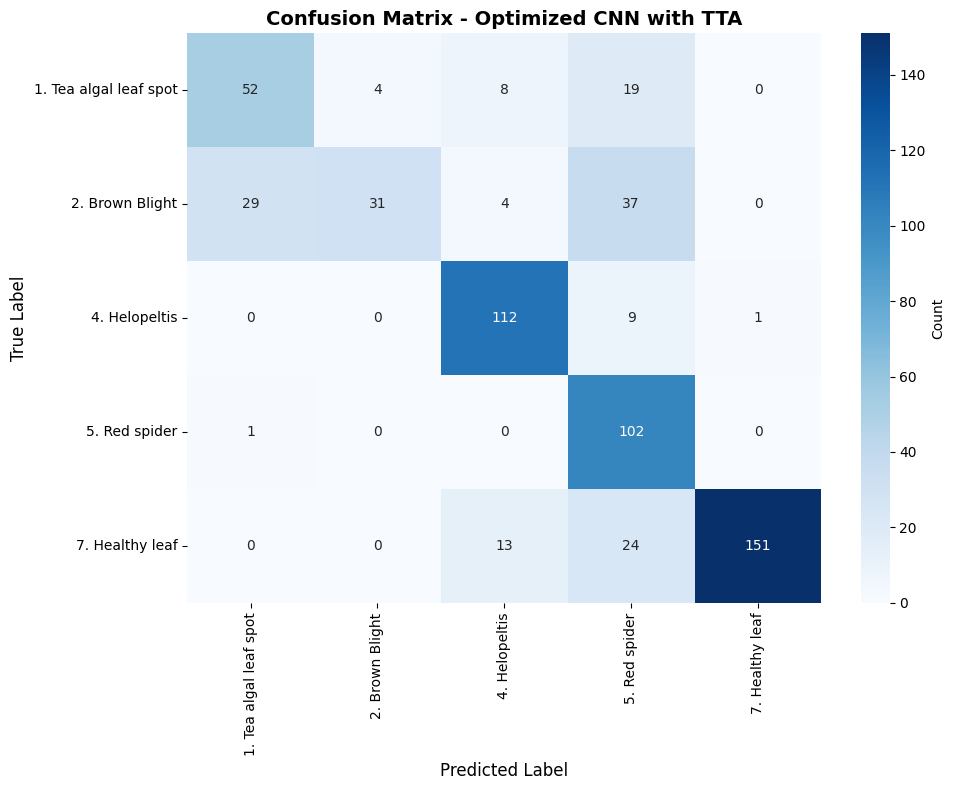


CLASSIFICATION REPORT
                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.6341    0.6265    0.6303        83
       2. Brown Blight     0.8857    0.3069    0.4559       101
         4. Helopeltis     0.8175    0.9180    0.8649       122
         5. Red spider     0.5340    0.9903    0.6939       103
       7. Healthy leaf     0.9934    0.8032    0.8882       188

              accuracy                         0.7504       597
             macro avg     0.7730    0.7290    0.7066       597
          weighted avg     0.8100    0.7504    0.7409       597



In [10]:
# ============================================================================
# 9. CONFUSION MATRIX
# ============================================================================
print("\n" + "="*80)
print("STEP 9: CONFUSION MATRIX VISUALIZATION")
print("="*80)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - Optimized CNN with TTA", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

In [16]:
# ============================================================================
# 10. K-FOLD CROSS-VALIDATION (SAFE & MEMORY-EFFICIENT)
# ============================================================================
print("\n" + "="*80)
print("STEP 10: 5-FOLD CROSS-VALIDATION (SAFE VERSION)")
print("="*80)

from sklearn.metrics import f1_score

# Convert train_data to arrays (if not already done)
X_data, y_data = [], []
for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_data.extend(X_batch)
    y_data.extend(y_batch)

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print(f"Training data shape: {X_data.shape}, Labels shape: {y_data.shape}")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, cv_precision, cv_recall, cv_f1 = [], [], [], []

epsilon = 1e-8  # small value to prevent division by zero
fold = 1

for train_idx, val_idx in kfold.split(X_data):
    print(f"\n{'='*50}\nFOLD {fold}/5\n{'='*50}")
    
    # Build fresh model for each fold
    model_fold = build_optimized_cnn(
        hyperparams,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        num_classes=NUM_CLASSES
    )
    
    # Compile model
    optimizer_fold = keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    model_fold.compile(
        optimizer=optimizer_fold,
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    # Callbacks
    cv_callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    
    # Train the model
    history_fold = model_fold.fit(
        X_data[train_idx],
        y_data[train_idx],
        validation_data=(X_data[val_idx], y_data[val_idx]),
        epochs=30,
        batch_size=BATCH_SIZE,
        callbacks=cv_callbacks,
        verbose=1
    )
    
    # Evaluate metrics
    scores = model_fold.evaluate(X_data[val_idx], y_data[val_idx], verbose=0)
    precision = scores[2]
    recall = scores[3]
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)  # safe F1
    
    print(f"Fold {fold} - Accuracy: {scores[1]:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    
    # Store metrics
    cv_scores.append(scores[1])
    cv_precision.append(precision)
    cv_recall.append(recall)
    cv_f1.append(f1)
    
    fold += 1

print(f"\n{'='*50}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*50}")
print(f"Mean Accuracy:  {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Mean Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Mean Recall:    {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"Mean F1-Score:  {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")



STEP 10: 5-FOLD CROSS-VALIDATION (SAFE VERSION)
Training data shape: (2000, 224, 224, 3), Labels shape: (2000, 5)

FOLD 1/5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.2519 - loss: 2.7623 - precision_12: 0.2790 - recall_12: 0.1079 - val_accuracy: 0.2250 - val_loss: 2.5352 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.3748 - loss: 2.2594 - precision_12: 0.5241 - recall_12: 0.1443 - val_accuracy: 0.1875 - val_loss: 3.2083 - val_precision_12: 0.1875 - val_recall_12: 0.1875 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4553 - loss: 2.0827 - precision_12: 0.5808 - recall_12: 0.2065
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.4553 - loss: 2.0825 - precision_12: 0.5810 - recall_12: 0.2066 - val_accuracy: 0.2075 - val_loss

In [17]:
# ============================================================================
# 11. SAVE COMPREHENSIVE RESULTS TO CSV
# ============================================================================
print("\n" + "="*80)
print("STEP 11: SAVING COMPREHENSIVE RESULTS")
print("="*80)

results_df = pd.DataFrame({
    'Model': ['Optimized CNN with TTA'],
    'Test_Accuracy': [acc],
    'Test_Precision': [prec],
    'Test_Recall': [rec],
    'Test_F1': [f1],
    'Test_AUC': [auc],
    'CV_Mean_Accuracy': [np.mean(cv_scores)],
    'CV_Std_Accuracy': [np.std(cv_scores)],
    'CV_Mean_Precision': [np.mean(cv_precision)],
    'CV_Mean_Recall': [np.mean(cv_recall)],
    'CV_Mean_F1': [np.mean(cv_f1)],
    'Training_Time_Minutes': [training_time/60],
    'Total_Epochs': [len(history.history['loss'])],
    'Batch_Size': [BATCH_SIZE],
    'Learning_Rate': [hyperparams['learning_rate']]
})

results_df.to_csv('optimized_cnn_results_tealeaf.csv', index=False)
print("✓ Results saved to optimized_cnn_results_tealeaf.csv")

print("\n" + "="*80)
print("OPTIMIZED CNN - TEA LEAF DISEASE DETECTION COMPLETE ✅")
print("="*80)
print(f"\nFinal Test Accuracy: {acc:.2%}")
print(f"Improvement strategies applied: 11")



STEP 11: SAVING COMPREHENSIVE RESULTS
✓ Results saved to optimized_cnn_results_tealeaf.csv

OPTIMIZED CNN - TEA LEAF DISEASE DETECTION COMPLETE ✅

Final Test Accuracy: 75.04%
Improvement strategies applied: 11
